# **Loan Default Prediction**

This notebook demonstrates **Exploratory Data Analysis (EDA)** on a loan dataset with a **binary target** (`bad_flag`).

## **Notebook Outline**
1. **Imports & Setup**
2. **Data Loading and Initial Inspection**
3. **Data Cleaning & Preprocessing**
4. **Exploratory Data Analysis (EDA)**
5. **Feature Selection & Final Preparation**
6. **Save Cleaned Data for Training**

We'll see both **Markdown explanations** (like this one) and **Code cells** demonstrating each step.

---

In [11]:
# (Cell 1) 1. Imports & Setup
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import RandomOverSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

plt.style.use('seaborn')  # optional aesthetics
print("Setup complete.")

Setup complete.


<ipython-input-11-7137d4bfe437>:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # optional aesthetics


## **2. Data Loading and Initial Inspection**
We assume you have a CSV file named `training_loan_data.csv`. Adjust `header` or `skiprows` as needed.

In [12]:
# (Cell 2) 2. Data Loading and Quick Look
df = pd.read_csv('training_loan_data.csv', header=1)  # Adjust path if necessary
print("Data loaded. Shape:", df.shape)
df.head()

Data loaded. Shape: (199121, 23)


,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,desc,purpose,...,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,application_approved_flag,internal_score,bad_flag
0,10000001,11983056.0,7550,36 months,16.24%,3 years,RENT,28000.0,NaN,debt_consolidation,...,0.0,17.0,72%,4000.0,NaN,3828.953801,5759.0,1,99,0.0
1,10000002,12002921.0,27050,36 months,10.99%,10+ years,OWN,55000.0,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,...,0.0,8.0,61.20%,35700.0,NaN,34359.940730,114834.0,1,353,0.0
2,10000003,11983096.0,12000,36 months,10.99%,4 years,RENT,60000.0,Borrower added on 12/31/13 > I would like to...,debt_consolidation,...,1.0,3.0,24%,18100.0,NaN,16416.617760,7137.0,1,157,0.0
3,10000004,12003142.0,28000,36 months,7.62%,5 years,MORTGAGE,325000.0,NaN,debt_consolidation,...,1.0,3.0,54.60%,42200.0,NaN,38014.149760,799592.0,1,365,0.0
4,10000005,11993233.0,12000,36 months,13.53%,10+ years,RENT,40000.0,NaN,debt_consolidation,...,0.0,17.0,68.80%,7000.0,53.0,6471.462236,13605.0,1,157,0.0


## **3. Data Cleaning & Preprocessing**
Here, we:
1. Convert textual columns (`term`, `int_rate`, `revol_util`, `emp_length`) to numeric.
2. Drop rows missing `bad_flag` (the target), since they can't be used for supervised learning.
3. Drop or impute columns with missing data.
4. One-hot encode categorical columns (`home_ownership`, `purpose`).
5. Remove ID-like or leak-prone columns (`id`, `member_id`, `application_approved_flag`).

In [13]:
# (Cell 3) Data Cleaning Functions

def convert_emp_length(x):
    """Converts strings like '10+ years', '3 years', '< 1 year' to integers."""
    if pd.isnull(x):
        return np.nan
    x = str(x).lower()
    if '10+' in x:
        return 10
    elif '< 1' in x:
        return 0
    match = re.search(r'(\d+)', x)
    if match:
        return int(match.group(1))
    return np.nan

# Convert 'term' from '36 months' -> 36
if 'term' in df.columns:
    df['term'] = df['term'].str.replace(' months', '', regex=False)
    df['term'] = pd.to_numeric(df['term'], errors='coerce')

# Convert percentage columns
for col in ['int_rate', 'revol_util']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace('%', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert emp_length
if 'emp_length' in df.columns:
    df['emp_length'] = df['emp_length'].apply(convert_emp_length)

print("After basic conversions:")
print(df.info())

# Drop rows without bad_flag
df = df.dropna(subset=['bad_flag'])

# Drop textual 'desc' if it exists
if 'desc' in df.columns:
    df.drop(columns=['desc'], inplace=True)

# Impute special columns
if 'mths_since_last_major_derog' in df.columns:
    df['mths_since_last_major_derog'].fillna(999, inplace=True)
if 'mths_since_recent_inq' in df.columns:
    df['mths_since_recent_inq'].fillna(36, inplace=True)

# Impute numeric columns with median
num_impute_cols = [
    'tot_cur_bal', 'bc_util', 'percent_bc_gt_75', 
    'emp_length', 'tot_hi_cred_lim', 'total_bc_limit', 
    'revol_util', 'dti', 'inq_last_6mths', 
    'annual_inc', 'int_rate', 'term'
]
for col in num_impute_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

# One-hot encode selected categorical columns
categorical_cols = ['home_ownership', 'purpose']
for c in categorical_cols:
    if c in df.columns:
        # drop_first=True to avoid dummy trap
        df = pd.get_dummies(df, columns=[c], drop_first=True)

# Drop ID-like or leak columns
drop_cols = ['id', 'member_id', 'application_approved_flag']
df.drop(columns=drop_cols, errors='ignore', inplace=True)

print("Final shape after cleaning:", df.shape)
df.head()

After basic conversions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199121 entries, 0 to 199120
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           199121 non-null  int64  
 1   member_id                    189457 non-null  float64
 2   loan_amnt                    199121 non-null  int64  
 3   term                         189457 non-null  float64
 4   int_rate                     189457 non-null  float64
 5   emp_length                   181531 non-null  float64
 6   home_ownership               189457 non-null  object 
 7   annual_inc                   189457 non-null  float64
 8   desc                         82004 non-null   object 
 9   purpose                      189457 non-null  object 
 10  percent_bc_gt_75             180419 non-null  float64
 11  bc_util                      180333 non-null  float64
 12  dti                          1894

,loan_amnt,term,int_rate,emp_length,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,7550,36.0,16.24,3.0,28000.0,100.0,96.0,8.40,0.0,17.0,...,False,False,False,False,False,False,False,False,False,False
1,27050,36.0,10.99,10.0,55000.0,25.0,53.9,22.87,0.0,8.0,...,False,False,False,False,False,False,False,False,False,False
2,12000,36.0,10.99,4.0,60000.0,0.0,15.9,4.62,1.0,3.0,...,False,False,False,False,False,False,False,False,False,False
3,28000,36.0,7.62,5.0,325000.0,16.7,67.1,18.55,1.0,3.0,...,False,False,False,False,False,False,False,False,False,False
4,12000,36.0,13.53,10.0,40000.0,33.3,79.6,16.94,0.0,17.0,...,False,False,False,False,False,False,False,False,False,False


## **4. Exploratory Data Analysis (EDA)**
We'll do a quick check of missing values, distributions, correlation, etc.

Missing values after final cleaning:
loan_amnt                      0
home_ownership_NONE            0
purpose_vacation               0
purpose_small_business         0
purpose_renewable_energy       0
purpose_other                  0
purpose_moving                 0
purpose_medical                0
purpose_major_purchase         0
purpose_house                  0
purpose_home_improvement       0
purpose_debt_consolidation     0
purpose_credit_card            0
home_ownership_RENT            0
home_ownership_OWN             0
home_ownership_OTHER           0
bad_flag                       0
term                           0
internal_score                 0
tot_cur_bal                    0
tot_hi_cred_lim                0
mths_since_last_major_derog    0
total_bc_limit                 0
revol_util                     0
mths_since_recent_inq          0
inq_last_6mths                 0
dti                            0
bc_util                        0
percent_bc_gt_75               0
annual

,loan_amnt,term,int_rate,emp_length,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,internal_score,bad_flag
count,189457.000000,189457.000000,189457.000000,189457.000000,1.894570e+05,189457.000000,189457.000000,189457.000000,189457.000000,189457.000000,189457.000000,189457.000000,189457.000000,189457.000000,1.894570e+05,189457.000000,189457.000000
mean,14353.641987,41.657051,14.282718,6.088294,7.224330e+04,53.405224,67.098955,17.061084,0.803549,11.278211,58.391736,20020.282687,833.537673,20016.810116,1.290396e+05,187.629520,0.069293
std,8112.121438,10.186636,4.438100,3.490600,5.180483e+04,33.338047,25.500808,7.596941,1.032936,11.635608,22.999513,18534.058373,362.053678,18595.217308,1.406918e+05,105.444113,0.253952
min,1000.000000,36.000000,6.000000,0.000000,4.800000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,14.000000,0.000000
25%,8000.000000,36.000000,11.140000,3.000000,4.500000e+04,28.600000,50.900000,11.340000,0.000000,3.000000,42.500000,8100.000000,999.000000,8073.189819,3.199800e+04,105.000000,0.000000
50%,12175.000000,36.000000,14.090000,6.000000,6.200000e+04,50.000000,72.200000,16.780000,0.000000,7.000000,60.500000,14700.000000,999.000000,14637.479485,8.076050e+04,159.000000,0.000000
75%,20000.000000,36.000000,17.270000,10.000000,8.700000e+04,80.000000,88.300000,22.580000,1.000000,15.000000,76.600000,25700.000000,999.000000,25703.471630,1.855840e+05,261.000000,0.000000
max,35000.000000,60.000000,26.060000,10.000000,7.141778e+06,100.000000,339.600000,34.990000,8.000000,36.000000,140.400000,522210.000000,999.000000,520643.298200,8.000078e+06,456.000000,1.000000


<Figure size 1080x720 with 0 Axes>

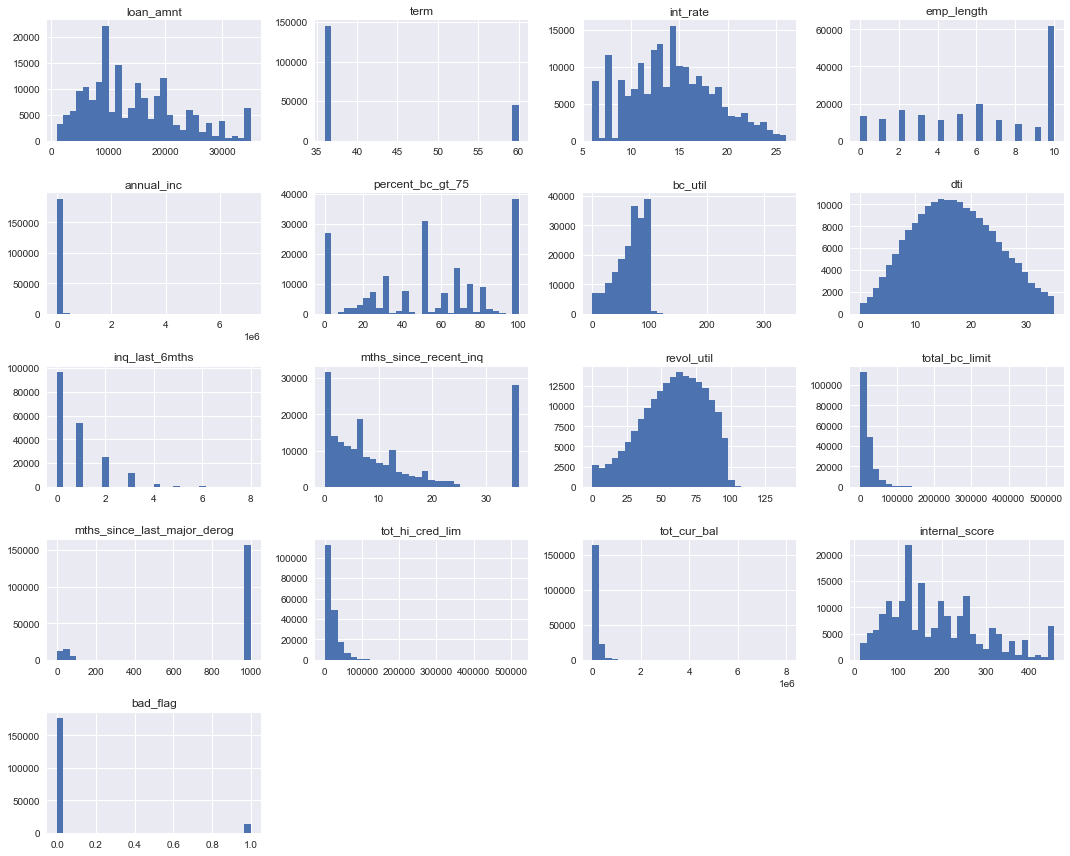

Correlation with bad_flag:
 bad_flag                       1.000000
int_rate                       0.120711
inq_last_6mths                 0.059158
home_ownership_RENT            0.045123
percent_bc_gt_75               0.045105
bc_util                        0.043382
purpose_small_business         0.043364
revol_util                     0.041092
dti                            0.039641
term                           0.038078
purpose_other                  0.027635
mths_since_last_major_derog    0.017466
purpose_medical                0.011028
purpose_debt_consolidation     0.010501
purpose_moving                 0.010147
loan_amnt                      0.009112
internal_score                 0.009109
purpose_renewable_energy       0.008641
purpose_wedding                0.006596
purpose_house                  0.005979
purpose_vacation               0.005575
home_ownership_OTHER           0.002418
home_ownership_NONE            0.001521
home_ownership_OWN             0.000371
purpose_majo

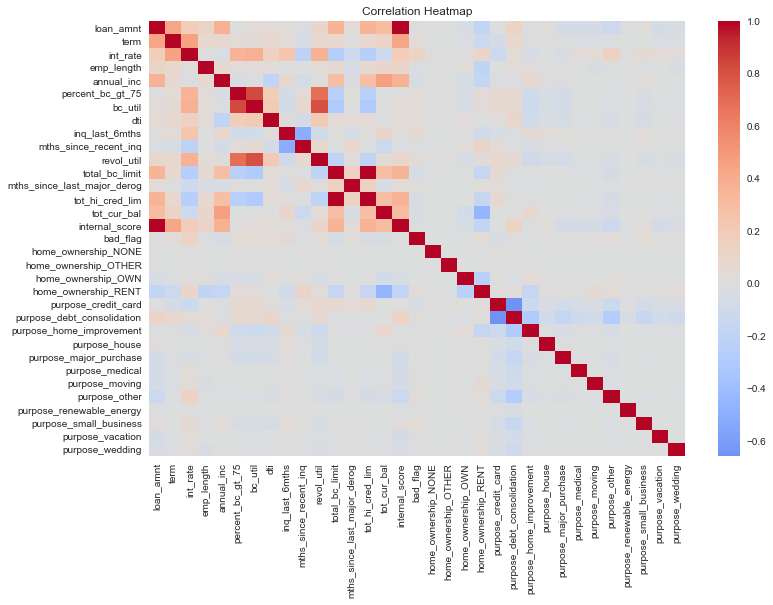

In [14]:
# (Cell 4) EDA
print("Missing values after final cleaning:")
print(df.isnull().sum().sort_values(ascending=False))

# Basic stats
display(df.describe())

# Distribution of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(15, 10))
df[numeric_cols].hist(bins=30, figsize=(15,12))
plt.tight_layout()
plt.show()

# Correlation with bad_flag
corr = df.corr()
corr_with_bad = corr['bad_flag'].sort_values(ascending=False)
print("Correlation with bad_flag:\n", corr_with_bad)

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

## **5. Feature Selection & Final Preparation**

In this step, we refine the feature set for the model by selectively removing columns based on their correlation with the target variable (`bad_flag`) and domain knowledge. While we do not apply aggressive feature selection techniques, the goal is to reduce noise, eliminate redundancy, and improve model interpretability and performance.

### **Columns Dropped:**
1. **`id`**: This is an identifier column that does not contain any predictive information for the target variable. It is unique for each row and has no correlation with `bad_flag`.

2. **`member_id`**: Similar to `id`, this is another unique identifier that holds no predictive value and is dropped for the same reason.

3. **`application_approved_flag`**: This column is constant (value is the same for all rows) and, therefore, does not contribute to model learning. It is removed to avoid redundancy.

4. **`desc`**: This column contains free-text data that was not preprocessed for this analysis. Including unprocessed textual data could add noise to the model, so it is dropped.

5. **Low-Correlation Features**:
   - After examining the correlation matrix, features with minimal correlation with `bad_flag` were considered for removal. These include:
     - `home_ownership_NONE`
     - `home_ownership_OTHER`
     - `purpose_major_purchase`
     - `purpose_home_improvement`
   - These features either had extremely low correlation with the target variable or were not deemed significant based on domain knowledge.

### **Final Feature Set:**
The remaining features after dropping are:

- **Numerical Features**:
  - `loan_amnt`
  - `term`
  - `int_rate`
  - `emp_length`
  - `annual_inc`
  - `percent_bc_gt_75`
  - `bc_util`
  - `dti`
  - `inq_last_6mths`
  - `mths_since_recent_inq`
  - `revol_util`
  - `total_bc_limit`
  - `mths_since_last_major_derog`
  - `tot_hi_cred_lim`
  - `tot_cur_bal`
  - `internal_score`

- **Categorical Features (One-Hot Encoded)**:
  - `home_ownership_RENT`
  - `home_ownership_OWN`
  - `purpose_credit_card`
  - `purpose_debt_consolidation`
  - `purpose_other`
  - `purpose_small_business`
  - `purpose_medical`
  - `purpose_moving`
  - `purpose_renewable_energy`
  - `purpose_wedding`

### **Reasoning:**
By retaining features with stronger correlation to `bad_flag` or higher domain relevance, we aim to:
- Improve the signal-to-noise ratio for the model.
- Simplify the feature set for better interpretability.
- Reduce unnecessary computation.

This minimal feature selection approach ensures the dataset is well-prepared for training without losing critical information.


In [17]:
# Drop low-impact columns based on correlation analysis
columns_to_drop = [
    'home_ownership_OTHER', 'home_ownership_NONE', 'home_ownership_OWN',
    'purpose_major_purchase', 'purpose_home_improvement', 'mths_since_recent_inq',
    'emp_length', 'purpose_credit_card', 'annual_inc', 'tot_cur_bal',
    'tot_hi_cred_lim', 'total_bc_limit'
]

df = df.drop(columns=columns_to_drop, errors='ignore')


## **5. Save Cleaned Data for Training**
We will save the data so that we can directly load it and train our model.

In [18]:
df.to_csv("cleaned_train_data.csv", index=False)
